**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torch.cuda

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import pretrainedmodels
import pickle

**Set Arguments**

In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'
    
DATA_DIR = ''        # directory of dataset

NUM_CLASSES = 101    # 101 + 1: There is am extra Background class that should be removed

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
    
SPLIT_SIZE = 0.2

LR = 1e-2            # The initial Learning Rate

MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10


**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
    
# Define transforms for training phase    
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Resize(256),      
                                      transforms.CenterCrop(224),                        
                                      transforms.ToTensor(),    
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Normalizes tensor with mean and standard deviation of ImageNet
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])             

**Prepare Dataset**

In [4]:
# Prepare Pytorch train/test Datasets
# in this case I'm reading from the same root as my data Images
from caltech_dataset import Caltech

# Creating Custom Dataset and DataLoaders
train_dataset = Caltech(DATA_DIR, split='train',split_size=SPLIT_SIZE, transform=train_transform)
val_dataset = Caltech(DATA_DIR, split='validation',split_size=SPLIT_SIZE, transform=eval_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Validation Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Total number of classes: 101
Total number of classes: 101
Total number of classes: 101
Train Dataset: 4627
Validation Dataset: 1157
Test Dataset: 5784


<!-- # xx=Caltech(DATA_DIR, split='train')
# xx.__getitem__(36) -->

**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
#Accessing Data in the training set and checking Data loader Class

# batch=next(iter(val_dataloader))
# # print(batch.shape)
# img, label = batch
# plt.imshow(img[255].squeeze().permute(1, 2, 0))
# a= Caltech(DATA_DIR, split='train', transform=train_transform)
# a.dict_keys_arr[label[255].squeeze()]

**Prepare Network (for training with AlexNet)**

In [7]:
# Loading AlexNet model
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
# nn.Linear in pytorch is a fully connected layer
                                                     # The convolutional layer is nn.Conv2d
net = alexnet(pretrained=True) 
    #pretrained (bool) – If True, returns a model pre-trained on ImageNet
    
    
#     for param in net.parameters():
#         param.requires_grad = False
        
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
#     net.classifier[6].requires_grad = True

**Prepare Network (going beyond alexnet and training on ResNet34)**

In [8]:
# #going beyond alexnet and training on ResNet34 which its weights are pretrained on ImageNet
# net = resnet34(pretrained=True)
# net.l0 = nn.Linear(512, NUM_CLASSES)
# net.dropout = nn.Dropout2d(0.4)

**Prepare Training**

In [9]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


In [10]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


**Train & Validation**

In [11]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime

current_step = 0
all_train_loss, all_train_acc =[], []
all_val_loss, all_val_acc =[], []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    
    net.train() # Sets module in training mode
    running_loss = 0.0
    running_correct = 0
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    # Iterate over the dataset
    for images, labels in train_dataloader:
    # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad() # Zero-ing the gradients        
        
        # Forward pass to the network
        outputs = net(images)
        # Compute loss based on output and ground truth
        loss = criterion(outputs, torch.max(labels, 1)[1])
        
        #computation of total training loss in each epoch
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(labels, 1)[1]).sum().item()
        
        
        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients
    

    train_loss = running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * running_correct/len(train_dataloader.dataset)      
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    all_train_loss.append(train_loss)
    all_train_acc.append(train_accuracy)


    net.eval() # Set Network to evaluation mode
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
        # Bring data over the device of choice
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass to the network
            outputs = net(images)
            # Compute loss based on output and ground truth
            loss = criterion(outputs, torch.max(labels, 1)[1])

            #computation of total training loss in each epoch
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(labels, 1)[1]).sum().item()

        val_loss = running_loss/len(train_dataloader.dataset)
        val_accuracy = 100. * running_correct/len(val_dataloader.dataset)      
        print(f"  Val Loss: {val_loss:.4f},  Val Acc: {val_accuracy:.2f}") 
        all_val_loss.append(val_loss)
        all_val_acc.append(val_accuracy)
    
        
# Step the scheduler
scheduler.step() 

Starting epoch 1/20, LR = [0.01]
Train Loss: 0.0094, Train Acc: 46.08
  Val Loss: 0.0008,  Val Acc: 65.86
Starting epoch 2/20, LR = [0.01]
Train Loss: 0.0023, Train Acc: 82.82
  Val Loss: 0.0006,  Val Acc: 71.13
Starting epoch 3/20, LR = [0.01]
Train Loss: 0.0013, Train Acc: 90.02
  Val Loss: 0.0005,  Val Acc: 73.98
Starting epoch 4/20, LR = [0.01]
Train Loss: 0.0009, Train Acc: 92.82
  Val Loss: 0.0006,  Val Acc: 73.03
Starting epoch 5/20, LR = [0.01]
Train Loss: 0.0006, Train Acc: 94.47
  Val Loss: 0.0006,  Val Acc: 74.42
Starting epoch 6/20, LR = [0.01]
Train Loss: 0.0004, Train Acc: 96.41
  Val Loss: 0.0006,  Val Acc: 73.73
Starting epoch 7/20, LR = [0.01]
Train Loss: 0.0003, Train Acc: 97.23
  Val Loss: 0.0005,  Val Acc: 75.02
Starting epoch 8/20, LR = [0.01]
Train Loss: 0.0003, Train Acc: 97.54
  Val Loss: 0.0006,  Val Acc: 75.45
Starting epoch 9/20, LR = [0.01]
Train Loss: 0.0003, Train Acc: 97.49
  Val Loss: 0.0005,  Val Acc: 74.33
Starting epoch 10/20, LR = [0.01]
Train Loss: 

**Saving & Plotting Results**

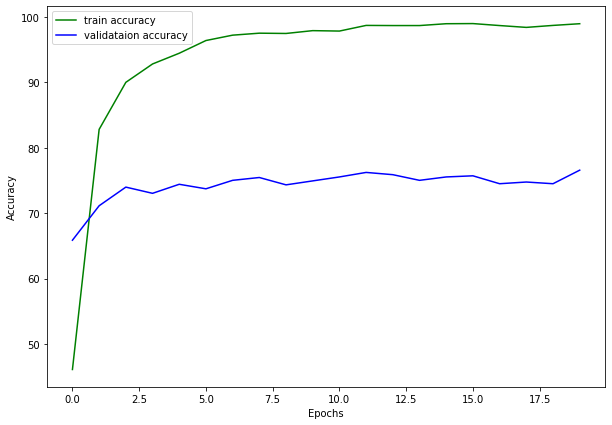

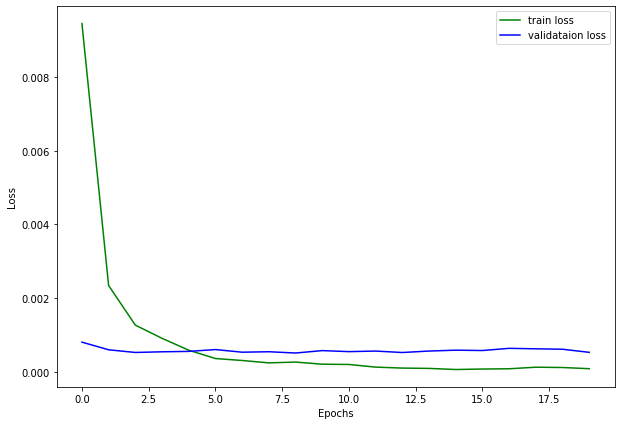

In [12]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(all_train_acc, color='green', label='train accuracy')
plt.plot(all_val_acc, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
 
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(all_train_loss, color='green', label='train loss')
plt.plot(all_val_loss, color='blue', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

**Test**

In [13]:
#Test
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.max(labels, 1)[1]).sum().item()

print('Accuracy of the network on test images: %0.1f %%' % (100 * correct / total))

100%|██████████| 23/23 [00:10<00:00,  2.25it/s]

Accuracy of the network on test images: 97.1 %
